# Scotch data
* Present interesting observation from the dataset
* Pick one Whiskey of choice, find similar options and explain model choice

*The data consists of multiple charatacteristics of chosen whiskies, including Jackson's five features, distilleries score, region, geo coordinates. The author considers the approach to classify the whisky types by taste profile (Jackson features), then apply the clusters on a map with their associated region to verify if geographic location can impact whiskies' taste profile*

*Method: Unsupervised learning: no labels provided, we want to group whiskies type by their specific feature, then validate with other attributes.*

*Algorithm: K- mean, iterates through a range of cluster (maximum equal number of regions) to get the best performing K.*
*With the result we then cross compare with data to see what other attribute closely correlate with Taste profile.*

## Import useful modules

In [1]:
pip install pyshp

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install shapely #for geo mapping

In [ ]:
pip install geopandas #for geo mapping

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
from shapely.geometry import Point, Polygon
import geopandas as gpd

## Import and glimpse at data

In [3]:
df= pd.read_excel("scotch.xlsx") #import main dataset
df.head()
df.shape

/Users/tochi/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/tochi/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


(112, 85)

***Import distilleries coordinates***

In [66]:
with open('DISTCOOR.txt') as f:
    coor = f.readlines()[7:]
    
coor= [item.split() for item in coor]
coor= pd.DataFrame(coor).iloc[:,0:3]
coor.columns= ["Name", "long", "lat"]

## Clean data

* Only 109 whisky types, remove the last invalid 2 rows

In [67]:
df=df[1:-2] #Remove the last 2 rows
df.shape

(106, 85)

In [68]:
taste_profile=df.iloc[:,0:70] #extract only columns contain taste profile (68 columns according to data description)
taste_profile= taste_profile.drop(["Unnamed: 1"], axis=1) #remove unccessary column

In [69]:
taste_profile.rename(columns={"Unnamed: 0": "Name"}, inplace=True) #Rename region column name

Upon checking REGIONS file, there are 3 distinct regions

In [207]:
region= pd.read_csv('REGIONS.txt')

## Applying K-means

In [73]:
from sklearn.cluster import KMeans

Since there are 3 regions, plus the previous histograms might have hinted, we would start with K=3

We set up kmeans below to go with k-means++ method >faster to reach convergence, n_cluster=3, and the algorithm will run 12 times with different centroids seed.

In [74]:
k_means= KMeans(init= 'k-means++', n_clusters=3, n_init=12)

Fit K-means model on dataset and add column lables to the taste_profile

In [200]:
k_means.fit(taste_profile.iloc[:,2:])
taste_profile['cluster']=k_means.labels_

KMeans(n_clusters=5, n_init=12)

## Visualization

Join taste_profile data with region, rename as combined_df

In [202]:
combined_df=pd.merge(taste_profile,coor, on="Name", how="left")

Transform longtitude and latitude to Point type from decimal degree. Readjust long and lat per file description (Longtitude is 1.87 times longer than Latitude)

In [212]:
combined_df['geometry']=[Point(xy) for xy in zip (pd.to_numeric(combined_df['long'])/1.87, 
                                                  pd.to_numeric(combined_df['lat']))]

/Users/tochi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Create geo dataframe, specify dataset, coordinate reference system, and geometry data (points created above)

In [204]:
geo_df= gpd.GeoDataFrame(combined_df,  #our dataset
                        crs= 'EPSG:4326', #coordinate reference system
                        geometry=combined_df['geometry'])

Create a map using Geo pandas. Not sure if I am using the wrong CRS or I needed to convert the shapefile to align the cluster on top of the map.

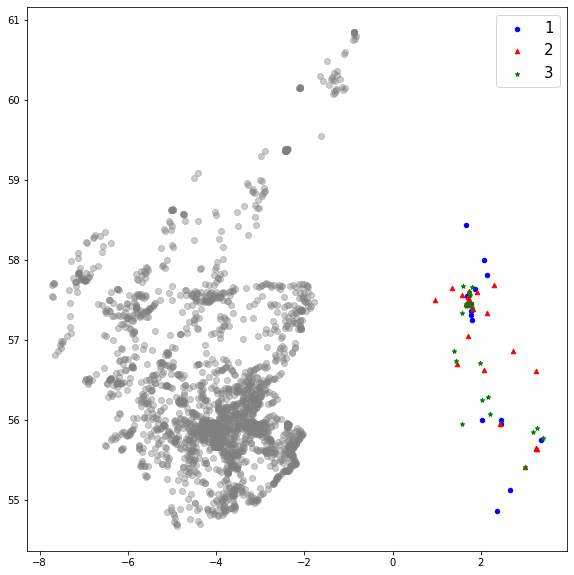

In [205]:
scot= gpd.read_file('places.shx') #Download Scotland shapefile... on Google :D 
fig, ax=  plt.subplots(figsize =(10,10)) #Set up blank plot
scot.plot(ax=ax, alpha=0.4, color='grey') #Plot Scotland map, not polygon, but close
geo_df[geo_df['cluster']==1].plot(ax= ax, markersize=20, color= 'blue', marker='o',label = 1) #add cluster 1
geo_df[geo_df['cluster']==2].plot(ax= ax, markersize=20, color= 'red', marker='^',label = 2) #add cluster 2
geo_df[geo_df['cluster']==0].plot(ax= ax, markersize=20, color= 'green', marker='*',label = 3) #add cluster 3
plt.legend(prop={'size':15})

Looks like there is no clear REGIONAL cluster with k=3, try k=5

/Users/tochi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


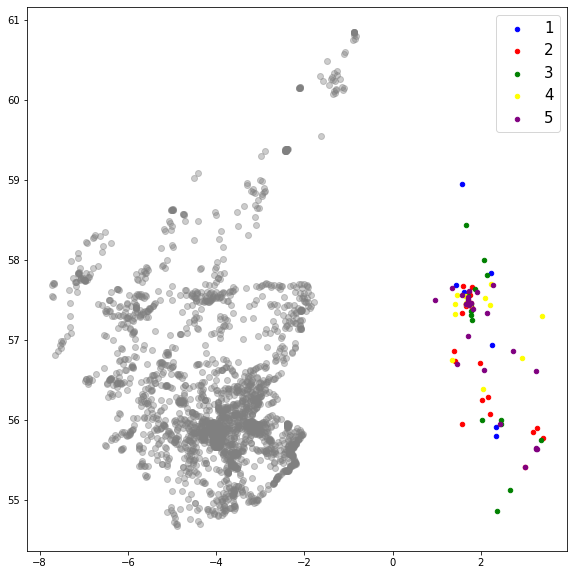

In [206]:
k_means= KMeans(init= 'k-means++', n_clusters=5, n_init=12)
k_means.fit(taste_profile.iloc[:,2:])

combined_df['cluster']=k_means.labels_
combined_df['geometry']=[Point(xy) for xy in zip (pd.to_numeric(combined_df['long'])/1.87,
                                                  pd.to_numeric(combined_df['lat']))]
geo_df= gpd.GeoDataFrame(combined_df,  #our dataset
                        crs= 'EPSG:4326', #coordinate reference system
                        geometry=combined_df['geometry'])
fig, ax=  plt.subplots(figsize =(10,10)) #Set up blank plot
scot.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['cluster']==0].plot(ax= ax, markersize=20, color= 'blue', marker='o',label = 1) #add cluster 1
geo_df[geo_df['cluster']==1].plot(ax= ax, markersize=20, color= 'red', marker='o',label = 2) #add cluster 2
geo_df[geo_df['cluster']==2].plot(ax= ax, markersize=20, color= 'green', marker='o',label = 3) #add cluster 3
geo_df[geo_df['cluster']==3].plot(ax= ax, markersize=20, color= 'yellow', marker='o',label = 4) #add cluster 4
geo_df[geo_df['cluster']==4].plot(ax= ax, markersize=20, color= 'purple', marker='o',label = 5) #add cluster 5

plt.legend(prop={'size':15})

We try with K from 2 to 7, but no clear clusters was found in the map base on Taste profile. Hence it is a inconclusive on the relationship between taste similarity and production land.

# CONCLUSION

We have used K_mean to group these whiskies base on similarity on Jackson's feature. The orginal hypothesis that there is correlation between taste profile and region has not been proved.
At best, I am able to advise you which alternative Whisky to buy at the store when your favorite one runs out, hopefully you'll enjoy it just as much....

In [217]:
name_type=['Name', 'cluster']
combined_df[name_type].sort_values('cluster')

,Name,cluster
31,Dalwhinnie,0
48,Glenglassaugh,0
58,Glen Moray,0
83,Longmorn,0
62,Glen Spey,0
...,...,...
77,Lagavulin,4
78,Laphroaig,4
79,Linkwood,4
81,Lochnagar,4


What else 